# Livrable 2 - Image processing

## The subject
The goal is to process a set of photographs by denoising them in order to make them better processable by Machine Learning algorithms. In this Jupyter notebook we will explain the pre-processing steps. The algorithms will rely on convolutional auto-encoders, and apply them to improve the image quality.

## Import

### Disable Tensorflow's warnings

In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
RUN_DIR = 'data/'

In [2]:
import tensorflow as tf
import numpy as np
from skimage.transform import resize
from keras.preprocessing import image
from matplotlib import pyplot as plt
from keras_preprocessing.image import ImageDataGenerator

2022-10-18 11:42:34.517184: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


## Global Variables

In [3]:
BATCH_SIZE: int = 64
IMG_HEIGHT: int = 228
IMG_WIDTH: int = 228
EPOCHS: int = 10
NO_NOISY_DATASET_PATH: str = RUN_DIR + 'data_ae/no_noisy'
NOISY_DATASET_PATH: str = RUN_DIR + 'data_ae/noisy'

## Load dataset

In [4]:
datagen = ImageDataGenerator(
    rescale=1. / 255,
    data_format="channels_last",
    validation_split=0.20
)

# Train
train_data = datagen.flow_from_directory(
    RUN_DIR + '/data_ae/no_noisy',
    subset='training',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode=None,
).next()

# Train noisy
train_noisy_data = datagen.flow_from_directory(
    RUN_DIR + '/data_ae/noisy',
    subset='training',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode=None,
).next()

# Test
test_data = datagen.flow_from_directory(
    RUN_DIR + '/data_ae/no_noisy',
    subset='validation',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode=None,
).next()

# Test noisy
test_noisy_data = datagen.flow_from_directory(
    RUN_DIR + '/data_ae/noisy',
    subset='validation',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=False,
    class_mode=None,
).next()

Found 7200 images belonging to 2 classes.
Found 7200 images belonging to 2 classes.
Found 1799 images belonging to 2 classes.
Found 1799 images belonging to 2 classes.


## Implementation of functions to display the images.

In [5]:
def display_single_image(img):
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis("off")


def display_image(x, n):
    plt.figure(figsize=(20, 2))
    for i in range(n):
        ax = plt.subplot(1, n, i + 1)
        plt.imshow(np.array(x[i]), vmax=1)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

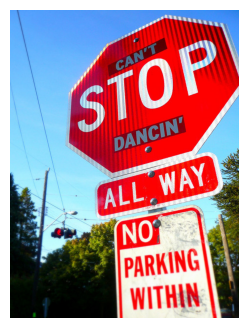

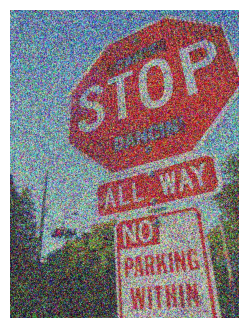

In [6]:
#Print an image of both datasets for testing
img = image.image_utils.load_img(NO_NOISY_DATASET_PATH + '/training/photo/photo_0003.jpg')
img_noisy = image.image_utils.load_img(NOISY_DATASET_PATH + '/training/photo/photo_0003.jpg')

display_single_image(np.array(img))
display_single_image(np.array(img_noisy))

Training set


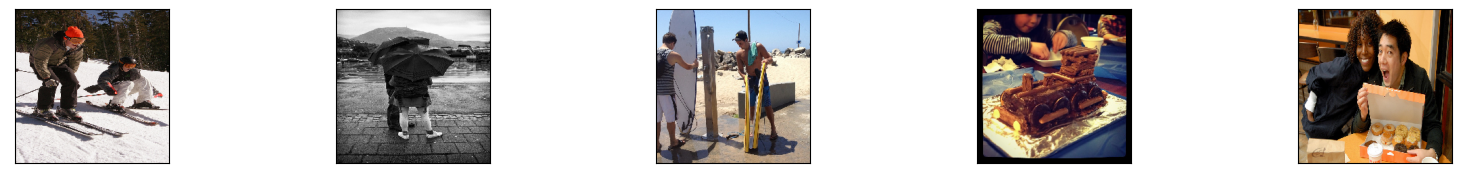

Noisy training set


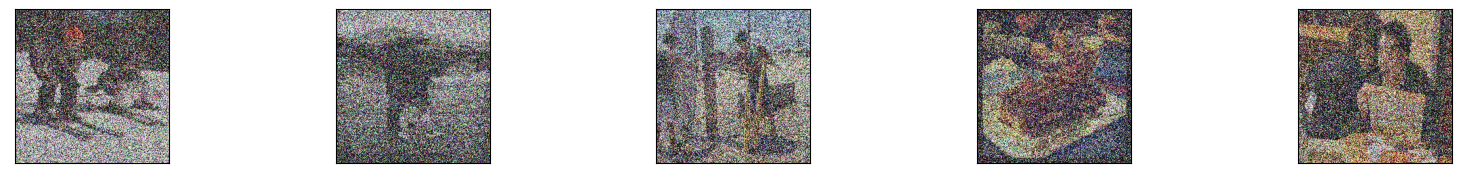

Validation Set


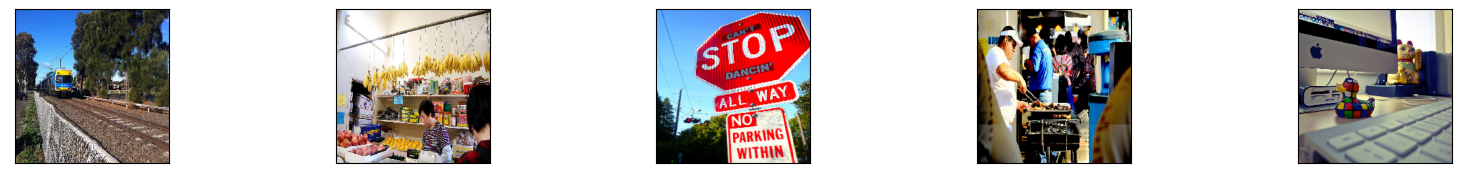

Noisy validation set


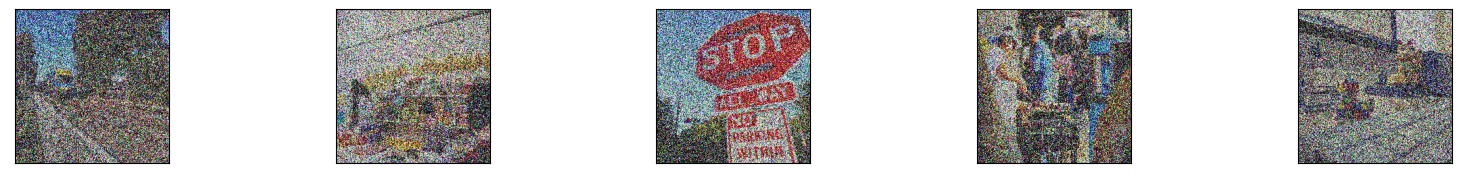

In [7]:
print("Training set")
display_image(train_data, 5)
print("Noisy training set")
display_image(train_noisy_data, 5)

print("Validation Set")
display_image(test_data, 5)
print("Noisy validation set")
display_image(test_noisy_data, 5)

## Encoder

In [8]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

encoder = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)
encoder = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')(encoder)
encoder = tf.keras.layers.MaxPooling2D((2, 2), padding='same')(encoder)

## Decoder

In [9]:
decoder = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(encoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=64, kernel_size=(3, 3), activation='relu', padding='same')(decoder)
decoder = tf.keras.layers.UpSampling2D((2, 2))(decoder)
decoder = tf.keras.layers.Conv2DTranspose(filters=3, kernel_size=(3, 3), activation='sigmoid', padding='same')(decoder)

## Auto encoder

In [10]:
auto_encoder = tf.keras.Model(inputs, decoder, name="auto_encoder")

auto_encoder.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss='binary_crossentropy')

## Save the best model

In [11]:
filename = RUN_DIR + "models/best_model.h5"
callback_best_model = tf.keras.callbacks.ModelCheckpoint(filepath=filename, verbose=0, save_best_only=True)

## Train the model

In [12]:
# auto_encoder.summary()

with tf.device('/GPU:0'):
    history = auto_encoder.fit(train_noisy_data, train_data,
                            batch_size=BATCH_SIZE,
                            epochs=EPOCHS,
                            verbose=1,
                            shuffle=True,
                            validation_data=(test_data, test_noisy_data),
                            callbacks=[callback_best_model]
                            )

Epoch 1/10
1/1 [==============================] - 5s 5s/step - loss: 0.6914 - val_loss: 0.6918
Epoch 2/10
1/1 [==============================] - 0s 382ms/step - loss: 0.6877 - val_loss: 0.6907
Epoch 3/10
1/1 [==============================] - 0s 378ms/step - loss: 0.6870 - val_loss: 0.6897
Epoch 4/10
1/1 [==============================] - 0s 362ms/step - loss: 0.6829 - val_loss: 0.6897
Epoch 5/10
1/1 [==============================] - 0s 384ms/step - loss: 0.6804 - val_loss: 0.6879
Epoch 6/10
1/1 [==============================] - 0s 380ms/step - loss: 0.6746 - val_loss: 0.6866
Epoch 7/10
1/1 [==============================] - 0s 361ms/step - loss: 0.6681 - val_loss: 0.6877
Epoch 8/10
1/1 [==============================] - 0s 359ms/step - loss: 0.6586 - val_loss: 0.6875
Epoch 9/10
1/1 [==============================] - 0s 362ms/step - loss: 0.6469 - val_loss: 0.6907
Epoch 10/10
1/1 [==============================] - 0s 356ms/step - loss: 0.6324 - val_loss: 0.6948
